# AutoML and hyperparameter tuning

In this notebook, we use the pycaret library to test many different models for the single-pixel regression task on the California dataset.

In [ ]:
!pip install pycaret

## Get data

In [6]:
from google.cloud.storage import Client
import pandas as pd
import random

client = Client(project="forest-lst")
bucket = "preisler_tfdata"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="preisler-rectangular")
    if f.name.endswith("csv") and not "v2" in f.name
]

random.shuffle(records)

ds = pd.concat((pd.read_csv(f).drop(["system:index", ".geo"], axis=1) for f in records), ignore_index=True)
ds.describe()

,fire,latitude,longitude,near,pct_mortality,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year
count,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000
mean,0.035538,38.729241,-120.921110,0.094709,0.036693,890.274912,904.502043,917.400381,927.187582,0.618464,-9.314954,2011.968381
std,0.164201,2.360971,1.895034,0.188841,0.116157,562.968146,569.931336,546.741807,551.616143,0.396780,6.412776,6.140651
min,0.000000,32.567223,-124.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-41.880527,2000.000000
25%,0.000000,37.135424,-122.548171,0.000000,0.000000,456.426167,469.380201,490.736208,493.392910,0.155901,-14.085734,2007.000000
50%,0.000000,39.169638,-120.967136,0.004400,0.000000,768.615228,778.353022,805.471707,815.382320,0.810296,-8.277435,2012.000000
75%,0.000000,40.739544,-119.565764,0.088000,0.004800,1208.003686,1225.228910,1248.191184,1268.501649,0.973267,-3.930672,2017.000000
max,2.000000,42.006813,-116.152166,1.000000,1.000000,4795.203592,4795.203592,3900.853290,4054.331371,1.000000,4.194588,2023.000000


## Set up experiment

In [10]:
from pycaret.regression import *

In [11]:
expt = setup(
    ds,
    target="pct_mortality",
    normalize=True, 
)

,Description,Value
0,Session id,4358
1,Target,pct_mortality
2,Target type,Regression
3,Original data shape,"(363674, 12)"
4,Transformed data shape,"(363674, 12)"
5,Transformed train set shape,"(254571, 12)"
6,Transformed test set shape,"(109103, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


## Run experiment

In [13]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Several statistical models and classical machine learning models are represented here. Many of these are tree-based regressors (random forest, extra trees) and boosted regressors (AdaBoost, XGBoost). There is also the cluster-based K-neighbors regressor and nonlinear regressors like ridge regression and lasso regression.

In [15]:
# Some of the tree-based methods are very slow. Since we have plenty of other regressors
# that do similarly well, we can skip some of these.
result = compare_models(exclude=["rf", "lightgbm", "gbr", "ada", "et"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.0208,0.0022,0.0472,0.8337,0.0385,2.7248,0.9630
knn,K Neighbors Regressor,0.0188,0.0026,0.0509,0.8065,0.0415,2.2692,2.9790
dt,Decision Tree Regressor,0.0187,0.0040,0.0632,0.7018,0.0518,2.3054,1.9280
ridge,Ridge Regression,0.0536,0.0098,0.0992,0.2662,0.0785,6.7802,0.1200
lr,Linear Regression,0.0536,0.0098,0.0992,0.2662,0.0785,6.7802,0.4930
lar,Least Angle Regression,0.0536,0.0098,0.0992,0.2662,0.0785,6.7802,0.1210
br,Bayesian Ridge,0.0536,0.0098,0.0992,0.2662,0.0785,6.7794,0.1510
omp,Orthogonal Matching Pursuit,0.0469,0.0109,0.1044,0.1880,0.0821,5.7162,0.1240
huber,Huber Regressor,0.0359,0.0131,0.1146,0.0217,0.0900,1.4170,0.8100
lasso,Lasso Regression,0.0587,0.0134,0.1158,-0.0001,0.0919,6.8554,0.1220


We find that the best-performing models are xgboost and, somewhat surprisingly, K-neighbors. Let's visualize their result and compare with standard linear regression.

In [23]:
xgb = create_model("xgboost", verbose=False)
knn = create_model("knn", verbose=False)
lr = create_model("lr", verbose=False)

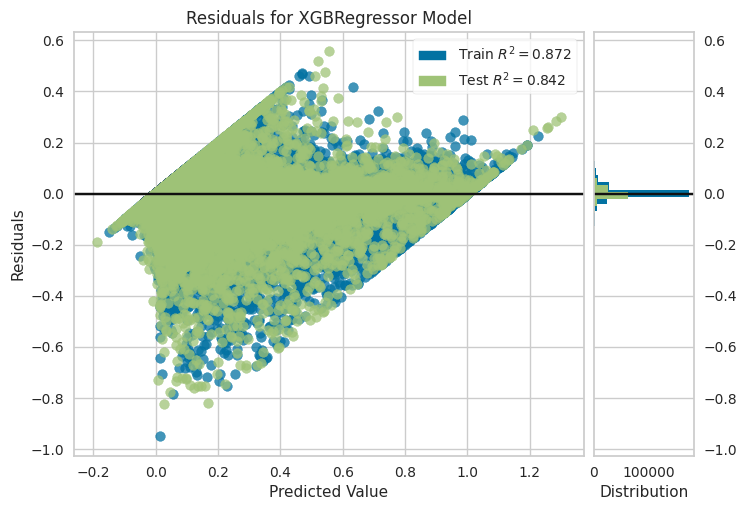

In [27]:
plot_model(xgb)

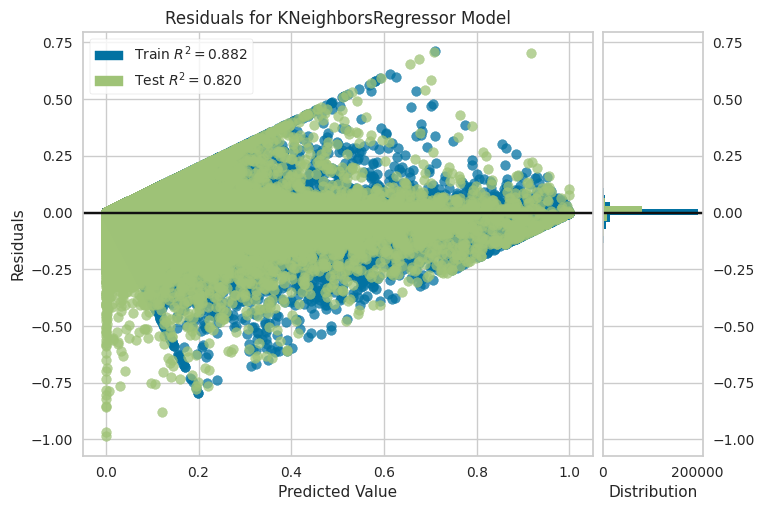

In [25]:
plot_model(knn)

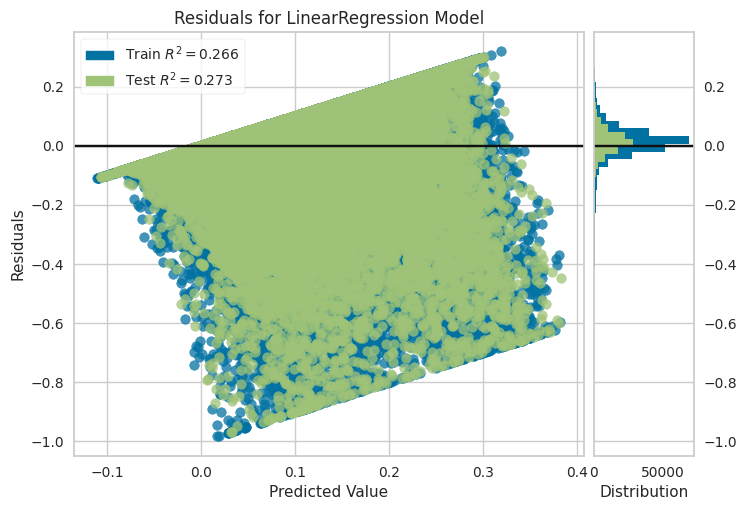

In [26]:
plot_model(lr)

The above figures are severely overplotted so it is kind of hard to tell what's going on. Regardless, it is clear that XGBoost is the winner in terms of performance. Incidentally, XGBoost is the hardest to interpret of the three model types here. With linear regression we can interpret the model by the regression coefficients. With KNN we have an intuitive explanation based on how the model is created: predictions are just the most similar observation in the data. But with XGBoost, we would have to resort to complex model interpretation tools like SHAP to see what is going on under the hood. In terms of computational complexity, each of these models fit within a reasonable amount of time on a training dataset of over 200,000 observations. KNN was actually the slowest at nearly 3 seconds per iteration. Ranking each model in terms of interpretability, performance, and computation time, we have:

| Model               | Interpretability | Performance | Computation time |
|---------------------|------------------|-------------|------------------|
| XGBoost             | 3                | 1           | 2                |
| Linear regression   | 1                | 3           | 1                |
| K-nearest neighbors | 2                | 2           | 3                |

Each model performs best on a different criterion. To decide on the best model, we have to pick a criterion that matches our use case. In this problem we prioritize performance and computation time over interpretability because our goal is to forecast future mortality. Therefore, XGBoost is the best model.

## Hyperparameter tuning

In [48]:
xgb_tuned = tune_model(xgb, fold=10, n_iter=10, optimize="RMSE", return_tuner=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0160,0.0015,0.0384,0.8910,0.0315,2.0958
1,0.0162,0.0015,0.0391,0.8915,0.0320,1.9764
2,0.0162,0.0016,0.0405,0.8765,0.0332,2.1345
3,0.0162,0.0015,0.0388,0.8822,0.0323,2.1740
4,0.0158,0.0015,0.0389,0.8867,0.0321,2.1868
5,0.0165,0.0016,0.0406,0.8767,0.0333,1.9349
6,0.0166,0.0017,0.0416,0.8661,0.0342,2.2765
7,0.0162,0.0016,0.0403,0.8811,0.0326,2.0811
8,0.0160,0.0015,0.0393,0.8784,0.0323,2.1796


Fitting 10 folds for each of 10 candidates, totalling 100 fits


The tuned model had a cross-validated RMSE of 4.00% vs. 4.72% for the default hyperparameter fit. What parameters changed?

In [69]:
keys = ["learning_rate", "min_child_weight", "reg_alpha", "reg_lambda", "scale_pos_weight", "subsample"]

tuned_params = {key:xgb_tuned[0].get_xgb_params()[key] for key in keys}

In [70]:
tuned_params

{'learning_rate': 0.3,
 'min_child_weight': 1,
 'reg_alpha': 0.2,
 'reg_lambda': 0.05,
 'scale_pos_weight': 0.6,
 'subsample': 0.9}

Default parameters below are taken from the XGBoost documentation. When pycaret fits a model it uses these.

In [71]:
default_params = dict(
    learning_rate=0.3,
    min_child_weight=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    subsample=0.5
)

In [74]:
pd.DataFrame.from_dict([tuned_params, default_params])

,learning_rate,min_child_weight,reg_alpha,reg_lambda,scale_pos_weight,subsample
0,0.3,1,0.2,0.05,0.6,0.9
1,0.3,1,0.0,1.00,1.0,0.5


From the above table, we see that the tuned model had a higher value of alpha, lower value of lambda, higher subsampling ratio, and lower positive weight scale. The last parameter is only involved in binary classification, so its inclusion here is probably in error. The other parameters have the following effect:

 - `subsample`: proportion of input data used to fit the tree. Increasing this value makes trees more consistent, and we avoid any risk of overfitting because of cross-validation.
 - `reg_alpha` and `reg_lambda`: Both of these parameters modify the loss function XGBoost uses to determine whether a tree should continue growing. Increasing either of these parameters makes for less complex trees, so the fact that lambda decreased while alpha increased suggests that their effects cancel out.

Hyperparameter tuning had very little effect on model performance. This interpretation is supported by our observation that hyperparameter changes had contradictory effects on the model.

## Save results

In [77]:
import os
os.chdir("..")

xgb.save_model("data_working/models/xgboost_preisler_v1.model")